In [1]:
import torch
import torchvision
import segmentation_models_pytorch
from pathlib import Path
import albumentations as albu
from glob import glob
import cv2
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
from sklearn.model_selection import train_test_split
import tqdm.notebook as tqdm
import torchvision
from tqdm import tqdm_gui,tqdm, tqdm_notebook
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [2]:
# getting list of path of images and their masks to prapre dataset
data_dir = '/data2/aditya/Damage_Model/new_damage_data/'
image_ids = list(Path(data_dir+"images").glob('**/*.png'))
mask_ids = list(Path(data_dir+"masks").glob('**/*.png'))
print(len(image_ids))
image_train_ids, image_valid_ids, mask_train_ids, mask_valid_ids = train_test_split(image_ids, mask_ids, test_size=0.2, random_state=42)

939


In [3]:
# visualise images and masks
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [5]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ["void", "damage"]
    
    def __init__(self, images_dir, masks_dir, classes=None, augmentation=None, preprocessing=None,):

        self.images_fps = images_dir
        self.masks_fps = masks_dir

        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(str(self.images_fps[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.masks_fps[i]), 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.images_fps)

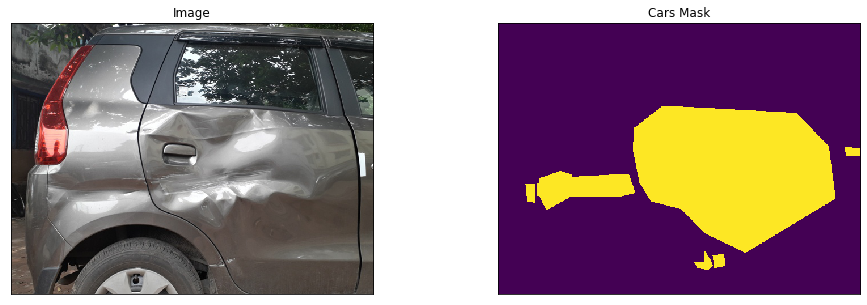

In [6]:
dataset = Dataset(image_train_ids, mask_train_ids, classes=["damage"])

image, mask = dataset[50] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [7]:
# defining training augmentations
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


# augmentation at the time of validation
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

# converting to tensor
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

# applying normalization
def preprocess_input(x, mean=None, std=None, input_space='RGB', input_range=None, **kwargs):

    if input_space == 'BGR':
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x

# defining a necessary prprocessinng function
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Resize(448, 448),
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

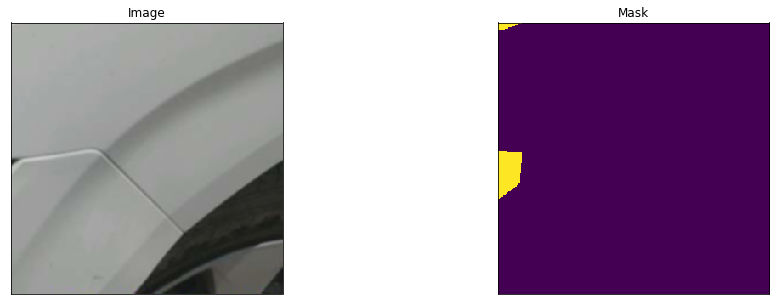

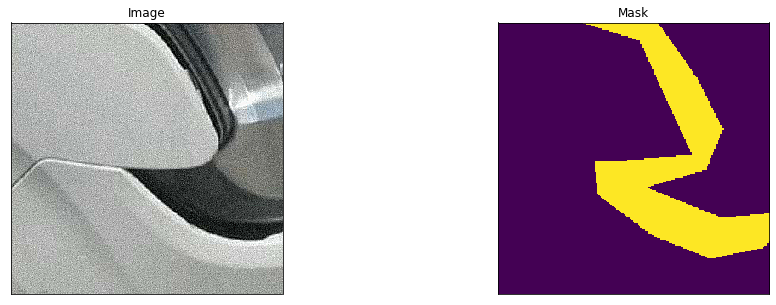

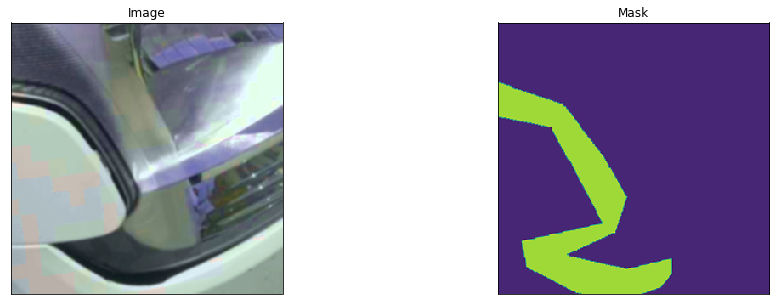

In [8]:
augmented_dataset = Dataset(image_train_ids, mask_train_ids, augmentation=get_training_augmentation(), classes=['damage'],)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))


In [27]:
model_ft = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=False, num_classes=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)
NUM_GPUS = torch.cuda.device_count()
if NUM_GPUS > 1:
    model_ft = torch.nn.DataParallel(model_ft)
    model_ft.to(device)
torch.cuda.set_device(0)
print(NUM_GPUS)

In [29]:
# defining a preprocessing function
preprocessing_fn  = partial(preprocess_input, input_space='RGB', input_range=[0, 1], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# defing a dataset for input of dataloader
CLASSES = ["damage"]
train_data = Dataset(
    image_train_ids, 
    mask_train_ids, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES)

In [30]:
# defining a training dataloader
data_loader = torch.utils.data.DataLoader(
                train_data, batch_size=4, shuffle=True, num_workers=NUM_GPUS,drop_last=True)

In [31]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0005)

In [32]:
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [34]:
# defining a DiceLoss function for training 
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
 
    def forward(self, logits, targets):
        ''' fastai.metrics.dice uses argmax() which is not differentiable, so it 
          can NOT be used in training, however it can be used in prediction.
          see https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L53
        '''
        N = targets.size(0)
        preds = torch.sigmoid(logits)
        EPSILON = 1e-7
 
        preds_flat = preds.view(N, -1)
        targets_flat = targets.view(N, -1)
 
        intersection = (preds_flat * targets_flat).sum()#.float()
        union = (preds_flat + targets_flat).sum()#.float()
        
        loss = (2.0 * intersection + EPSILON) / (union + EPSILON)
        loss = 1 - loss / N
        return loss

In [35]:
#defining engine for training
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    loss_func = DiceLoss() #nn.BCEWithLogitsLoss() 

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    lossf=None
    inner_tq = tqdm(data_loader, total=len(data_loader), leave=False)
    for images, masks in inner_tq:
        y_preds = model(images.to(device))
        y_preds = y_preds['out'][:, 1, :, :] #

        loss = loss_func(y_preds, masks.to(device))

        if torch.cuda.device_count() > 1:
            loss = loss.mean() # mean() to average on multi-gpu.

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if lr_scheduler is not None:
            lr_scheduler.step()

        if lossf:
            lossf = 0.98*lossf+0.02*loss.item()
        else:
            lossf = loss.item()
        inner_tq.set_postfix(loss = lossf)

In [ ]:
num_epochs = 70
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch)
    lr_scheduler.step()

In [ ]:
for param in model_ft.parameters():
    param.requires_grad = False
model_ft.to(torch.device('cuda'))
#assert model_ft.training == False

model_ft.eval()